In [1]:
import numpy as np
from netCDF4 import Dataset
import xarray
from wrf import to_np, ll_to_xy
from scipy import fftpack
from scipy.signal import welch
%matplotlib inline
import matplotlib.pyplot as plt
from pandas import Series

In [111]:
plt.rc("font",size=14)

In [2]:
les_25_path  = "/glade/scratch/doubrawa/postProcessing/WRF_LES_25m_2015-03-28_14:00_14:30.nc"
les_100_path = "/glade/scratch/doubrawa/postProcessing/WRF_LES_100m_2015-03-28_14:01_14:30.nc"

In [3]:
data_25  = xarray.open_dataset(les_25_path)
data_100 = xarray.open_dataset(les_100_path)

In [4]:
wrfnc_100 = Dataset("/glade/scratch/domingom/Cheyenne/XPIA_mesoLES/SIMULS/WRF_mesoLES_4dom_RAP_2015_03_12_mesoLES/HOUR_14_1/wrfout_d03_2015-03-13_14:01:00_0000")

In [5]:
datetimes_100 = data_100.time.data

In [6]:
datetime = datetimes_100[0]

### grab coordinates and quantity of interest

In [7]:
lat2d_25 = data_25.xlat
lon2d_25 = data_25.xlong
vals_25  = data_25.w.sel(time=datetime)

lat2d_100 = data_100.xlat
lon2d_100 = data_100.xlong
vals_100  = data_100.w.sel(time=datetime)

In [8]:
x_25_1d,y_25_1d = ll_to_xy(wrfnc_100, lat2d_25, lon2d_25)
y_25   = np.reshape(y_25_1d.data,(1200,1200))
x_25   = np.reshape(x_25_1d.data,(1200,1200))

In [9]:
x_100_1d,y_100_1d = ll_to_xy(wrfnc_100, lat2d_100, lon2d_100)
y_100   = np.reshape(y_100_1d.data,(1200,1200))
x_100   = np.reshape(x_100_1d.data,(1200,1200))

### plot qoi using lat/lon and x/y to check that they are the same

Text(0.5,0.98,'WRF-LES $\\Delta=25$ m')

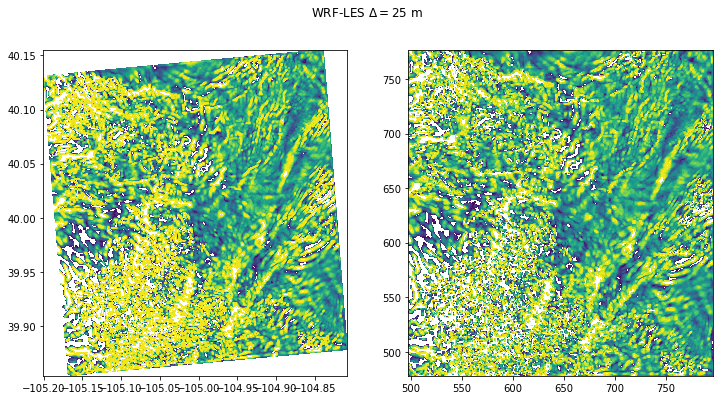

In [10]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.contourf(to_np(lon2d_25),to_np(lat2d_25),to_np(vals_25),levels=np.arange(-0.24,0.25,0.02))

ax2 = fig.add_subplot(1,2,2)
ax2.contourf(x_25,y_25,to_np(vals_25),levels=np.arange(-0.24,0.25,0.02))
fig.suptitle("WRF-LES $\Delta=25$ m")

Text(0.5,0.98,'WRF-LES $\\Delta=100$ m')

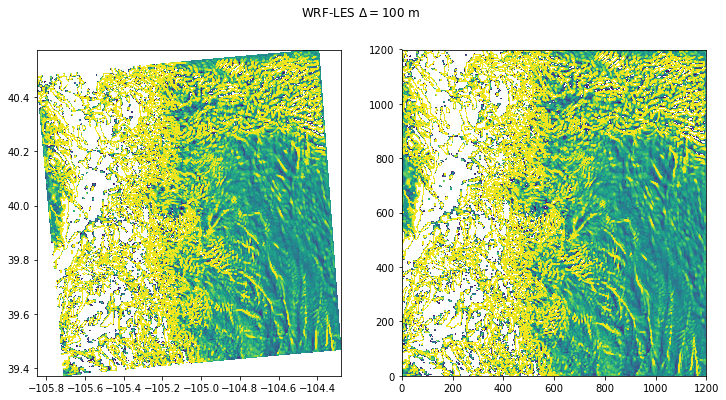

In [11]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.contourf(to_np(lon2d_100),to_np(lat2d_100),to_np(vals_100),levels=np.arange(-0.24,0.25,0.02))

ax2 = fig.add_subplot(1,2,2)
ax2.contourf(x_100,y_100,to_np(vals_100),levels=np.arange(-0.24,0.25,0.02))
fig.suptitle("WRF-LES $\Delta=100$ m")

### clip large domain to contain only points that small domain has

In [10]:
xmin, xmax = np.min(x_25), np.max(x_25)
ymin, ymax = np.min(y_25), np.max(y_25)

In [11]:
x_100_clip    = x_100[ymin:ymax+1,xmin:xmax+1]
y_100_clip    = y_100[ymin:ymax+1,xmin:xmax+1]
vals_100_clip = vals_100[ymin:ymax+1,xmin:xmax+1]

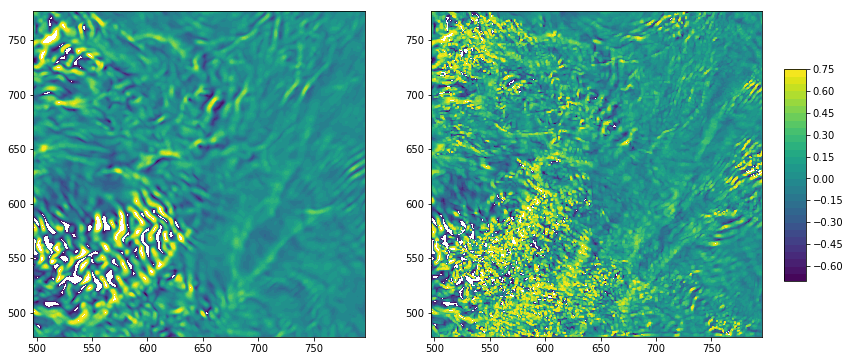

In [14]:
levels = np.arange(-0.7,0.7+1e-1,0.05)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
p1 = ax1.contourf(x_100_clip,y_100_clip,vals_100_clip,levels=levels)

ax2 = fig.add_subplot(1,2,2)
p2 = ax2.contourf(x_25,y_25,to_np(vals_25),levels=levels)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.255, 0.02, 0.49])
plt.colorbar(p2, cax=cbar_ax)

### Start filtering operations

In [12]:
v_25 = to_np(vals_25)
p_25 = fftpack.fft2(v_25, overwrite_x=False)
p_25 = fftpack.fftshift(p_25) #Shift the zero-frequency component to the center of the spectrum.
f_25 = fftpack.fftfreq(len(v_25),d=25.0)
f_25 = np.sort(f_25)

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [13]:
v_100 = to_np(vals_100_clip)
p_100 = fftpack.fft2(v_100, overwrite_x=False)
p_100 = fftpack.fftshift(p_100) #Shift the zero-frequency component to the center of the spectrum.
f_100 = fftpack.fftfreq(len(v_100), d=100.0)
f_100 = np.sort(f_100)

/gpfs/u/apps/ch/opt/python/2.7.14/intel/17.0.1/pkg-library/20180329/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


(0.005, -0.005)

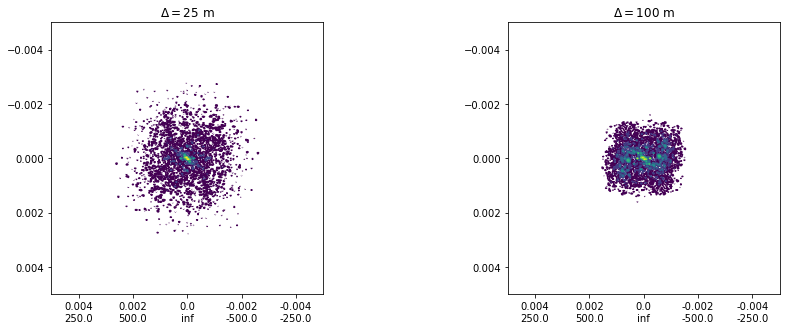

In [32]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1,aspect="equal")
ax1.contour(f_25,f_25,np.abs(p_25))
ax1.set_title("$\Delta=25$ m")

ax2 = fig.add_subplot(1,2,2,sharex=ax1,sharey=ax1,aspect='equal')
ax2.contour(f_100,f_100,np.abs(p_100))
ax2.set_title("$\Delta=100$ m")

ax2.set_xticks(np.arange(-0.004,0.0041,0.002))
ax2.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])

lim = -0.005
ax1.set_xlim([-lim,lim])
ax1.set_ylim([-lim,lim])

### Gaussian

In [14]:
# Build and apply a Gaussian filter.
nrows,ncols = v_25.shape
sigmax, sigmay = 100,100
cy, cx = nrows/2, ncols/2
x = np.linspace(0, nrows, nrows)
y = np.linspace(0, ncols, ncols)
X, Y = np.meshgrid(x, y)
gmask = np.exp(-(((X-cx)/sigmax)**2 + ((Y-cy)/sigmay)**2))

In [15]:
p_filt = p_25 * gmask

/gpfs/u/apps/ch/opt/python/2.7.14/intel/17.0.1/pkg-library/20180329/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


(0.005, -0.005)

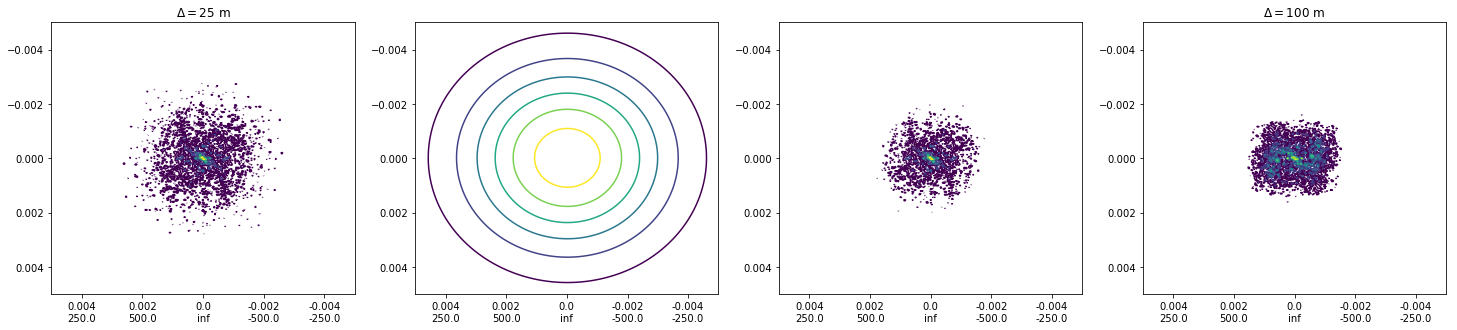

In [93]:
fig = plt.figure(figsize=(25,5))

ax1 = fig.add_subplot(1,4,1)
ax1.contour(f_25,f_25,np.abs(p_25))
ax1.set_title("$\Delta=25$ m")

ax2 = fig.add_subplot(1,4,2,sharex=ax1,sharey=ax1)
ax2.contour(f_25,f_25,gmask)

ax3 = fig.add_subplot(1,4,3,sharex=ax1,sharey=ax1)
ax3.contour(f_25,f_25,np.abs(p_filt))

ax4 = fig.add_subplot(1,4,4,sharex=ax1,sharey=ax1)
ax4.contour(f_100,f_100,np.abs(p_100))
ax4.set_title("$\Delta=100$ m")

ax3.set_xticks(np.arange(-0.004,0.0041,0.002))
ax3.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])

lim = -0.005
ax1.set_xlim([-lim,lim])
ax1.set_ylim([-lim,lim])

In [16]:
p_filt = fftpack.ifftshift(p_filt)
x_filt = fftpack.ifft2(p_filt)

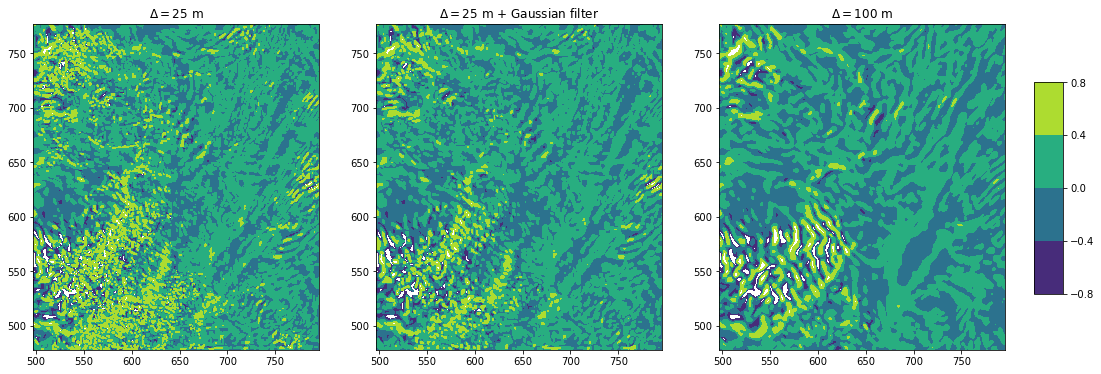

In [95]:
levels = np.arange(-0.8,0.8+1e-1,0.4)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
p1 = ax1.contourf(x_25,y_25,v_25,levels=levels)
ax1.set_title("$\Delta=25$ m")

ax2 = fig.add_subplot(1,3,2)
p2 = ax2.contourf(x_25,y_25,x_filt,levels=levels)
ax2.set_title("$\Delta=25$ m + Gaussian filter")

ax3 = fig.add_subplot(1,3,3)
p3 = ax3.contourf(x_100_clip,y_100_clip,vals_100_clip,levels=levels)
ax3.set_title("$\Delta=100$ m")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.255, 0.02, 0.49])
plt.colorbar(p2, cax=cbar_ax)

### Sharp cutoff

# JUNKYARD

In [23]:
#
# Get PSD along south_north;
# (one for each west_east, then averaged together)
#

n_west_east = int(vals_25["west_east"].shape[0])
for i in range(n_west_east):
    
    xx_25  = vals_25.isel(west_east=i)

    if i==0:
        ff_25, pp_25 = np.abs(welch(xx_25,fs=1/25.0))
    else:
        junk, now = np.abs(welch(xx_25,fs=1/25.0))
        pp_25 = pp_25 + now
pp_25 = pp_25/float(n_west_east)

n_west_east = int(vals_100_clip["west_east"].shape[0])
for i in range(n_west_east):
    
    xx_100  = vals_100_clip.isel(west_east=i)

    if i==0:
        ff_100, pp_100 = np.abs(welch(xx_100,fs=1/100.0))
    else:
        junk, now = np.abs(welch(xx_100,fs=1/100.0))
        pp_100 = pp_100 + now
pp_100 = pp_100/float(n_west_east)

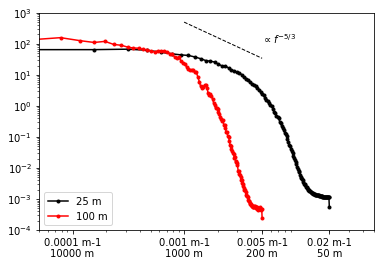

In [98]:
#
#  visualize the mean PSD obtained just above
#

fig = plt.figure()
ax  = fig.add_subplot(111)

ax.loglog(ff_25,pp_25,'.-k',label='25 m')
ax.loglog(ff_100,pp_100,'.-r',label='100 m')

ref_f     = np.linspace(1e-3,5e-3,20)
ref_slope = ref_f**(-5/3) * 5e-3
ax.loglog(ref_f,ref_slope,'--k',lw=1)
ax.text(5e-3,1e2,'$\propto f^{{-5/3}}$') 

kappas = [50.,200.,1000.,10000.0]
ax.set_xticks([1/q for q in kappas])
ax.set_xticklabels(["{0} m-1\n{1:.0f} m".format(1/q,q) for q in kappas])
ax.set_xlim([5e-5,5e-2])
ax.set_ylim([1e-4,1e3])
plt.legend(loc=3)

In [27]:
#
# the frequencies of each PSD above are different, because the resolution of the data is different
# thus, here we interpolate both PSD to the same frequencies to make comparison easier
#

fit_meters         = np.linspace(200.0,10000.0,500)
fit_inverse_meters = [1/l for l in fit_meters] 

pp_100_int = np.interp(fit_inverse_meters, ff_100, pp_100)
pp_25_int  = np.interp(fit_inverse_meters, ff_25,  pp_25)

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


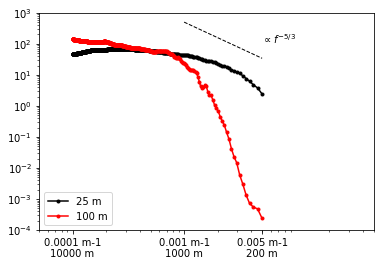

In [95]:
#
# check that it still looks the same as above
#

fig = plt.figure()
ax  = fig.add_subplot(111)

ax.loglog(fit_inverse_meters,pp_25_int,'.-k',label='25 m')
ax.loglog(fit_inverse_meters,pp_100_int,'.-r',label='100 m')
ax.set_xlim([5e-5,5e-2])
ax.set_ylim([1e-4,1e3])

ref_f     = np.linspace(1e-3,5e-3,20)
ref_slope = ref_f**(-5/3) * 5e-3
ax.loglog(ref_f,ref_slope,'--k',lw=1)
ax.text(5e-3,1e2,'$\propto f^{{-5/3}}$') 

kappas = [200.,1000.,10000.0]
ax.set_xticks([1/q for q in kappas])
ax.set_xticklabels(["{0} m-1\n{1:.0f} m".format(1/q,q) for q in kappas])

plt.legend(loc=3)

In [102]:
#
# identify point at which 100-m starts diverging from 25-m data by 0.2 log points
#
pp_100_int_log = np.log10(pp_100_int)
pp_25_int_log  = np.log10(pp_25_int)
ff_int_log     = np.log10(fit_inverse_meters)

diff           = Series(index=ff_int_log,data=(pp_100_int_log - pp_25_int_log)).sort_index()
f_cut_log      = diff[diff<-0.2].index[0]
f_cut          = (10**f_cut_log)

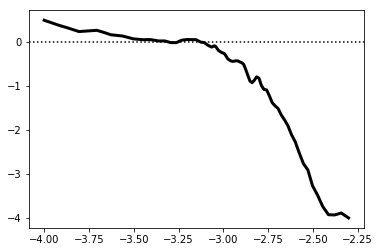

In [103]:
fig = plt.figure()
ax  = fig.add_subplot(111)

ax.axhline(y=0,color='k',linestyle=":")
ax.plot(diff,'-k',lw=3)

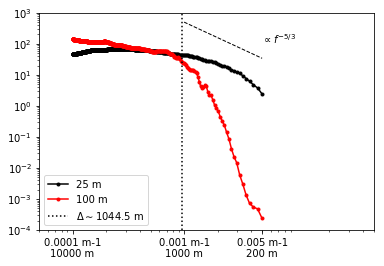

In [104]:
#
# see where that ended up
#

fig = plt.figure()
ax  = fig.add_subplot(111)

ax.loglog(fit_inverse_meters,pp_25_int,'.-k',label='25 m')
ax.loglog(fit_inverse_meters,pp_100_int,'.-r',label='100 m')
ax.set_xlim([5e-5,5e-2])
ax.set_ylim([1e-4,1e3])

ref_f     = np.linspace(1e-3,5e-3,20)
ref_slope = ref_f**(-5/3) * 5e-3
ax.loglog(ref_f,ref_slope,'--k',lw=1)
ax.text(5e-3,1e2,'$\propto f^{{-5/3}}$') 

ax.axvline(x=10**f_cut_log,color='k',linestyle=":",label="$\Delta\sim{0:.1f}$ m".format(1/f_cut))

kappas = [200.,1000.,10000.0]
ax.set_xticks([1/q for q in kappas])
ax.set_xticklabels(["{0} m-1\n{1:.0f} m".format(1/q,q) for q in kappas])

plt.legend(loc=3)

# END OF JUNKYARD

In [105]:
#
# now we are back into 2-d PSDs
# put frequencies in a grid to make this easier
#

f_25_gridx, f_25_gridy = np.meshgrid(f_25,f_25)
bfilt_25               = np.zeros(f_25_gridx.shape)

f_100_gridx, f_100_gridy = np.meshgrid(f_100,f_100)
bfilt_100                = np.zeros(f_100_gridx.shape)

In [106]:
#
# find where frequencies are beyond the identified cutoff and make a mask
#

idx_i, idx_j       = np.where( (np.abs(f_25_gridx)<f_cut)&(np.abs(f_25_gridy)<f_cut) )
bfilt_25[idx_i,idx_j] = 1.0

idx_i, idx_j       = np.where( (np.abs(f_100_gridx)<f_cut)&(np.abs(f_100_gridy)<f_cut) )
bfilt_100[idx_i,idx_j] = 1.0

In [107]:
p_filt_25 = p_25 * bfilt_25
p_filt_100 = p_100 * bfilt_100

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


(0.005, -0.005)

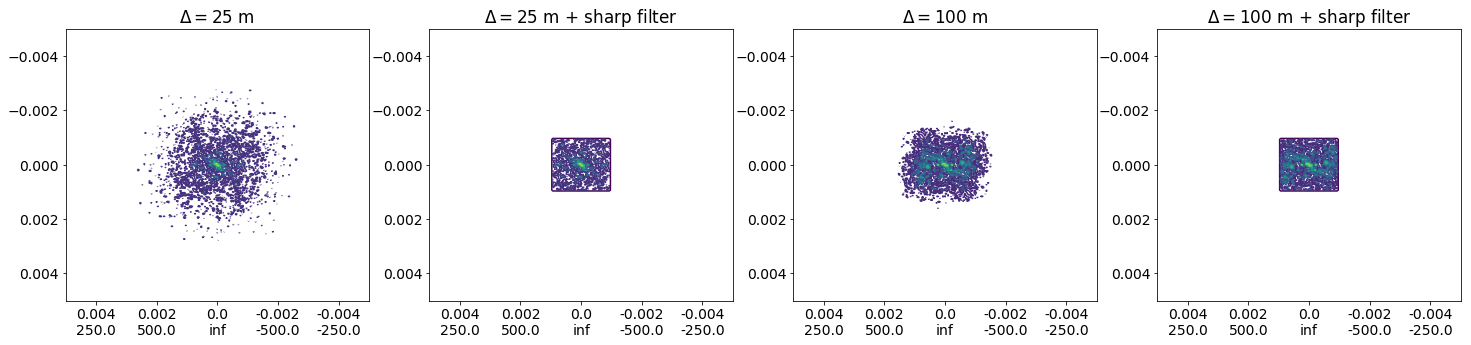

In [112]:
fig = plt.figure(figsize=(25,5))

#
# 25-m grid
#
ax1 = fig.add_subplot(1,4,1)
ax1.contour(f_25,f_25,np.abs(p_25))
ax1.set_title("$\Delta=25$ m")

ax2 = fig.add_subplot(1,4,2,sharex=ax1,sharey=ax1)
ax2.contour(f_25,f_25,np.abs(p_filt_25))
ax2.set_title("$\Delta=25$ m + sharp filter")

#
# 100-m grid
#

ax3 = fig.add_subplot(1,4,3,sharex=ax1,sharey=ax1)
ax3.contour(f_100,f_100,np.abs(p_100))
ax3.set_title("$\Delta=100$ m")

ax4 = fig.add_subplot(1,4,4,sharex=ax1,sharey=ax1)
ax4.contour(f_100,f_100,np.abs(p_filt_100))
ax4.set_title("$\Delta=100$ m + sharp filter")

ax3.set_xticks(np.arange(-0.004,0.0041,0.002))
ax3.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])

lim = -0.005
ax1.set_xlim([-lim,lim])
ax1.set_ylim([-lim,lim])

In [113]:
#
# shift fft back so zero is no longer in the middle, so we can do the inverse fft
#
p_filt_25_final  = fftpack.ifftshift(p_filt_25)
p_filt_100_final = fftpack.ifftshift(p_filt_100)

vals_filt_25  = fftpack.ifft2(p_filt_25_final)
vals_filt_100 = fftpack.ifft2(p_filt_100_final)

### Visualize results

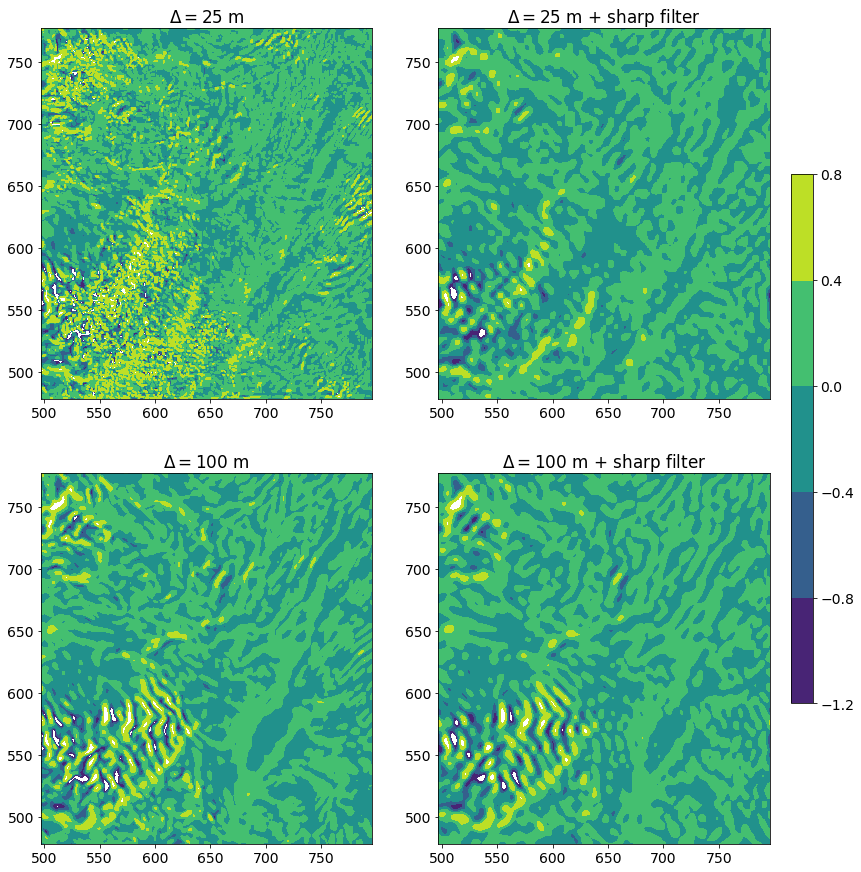

In [123]:
#
# contours
#

levels = np.arange(-1.2,0.8+1e-1,0.4)

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
p1  = ax1.contourf(x_25,y_25,v_25,levels=levels)
ax1.set_title("$\Delta=25$ m")

ax2 = fig.add_subplot(2,2,2)
p2 = ax2.contourf(x_25,y_25,vals_filt_25,levels=levels)
ax2.set_title("$\Delta=25$ m + sharp filter")

ax3 = fig.add_subplot(2,2,3)
p3 = ax3.contourf(x_100_clip,y_100_clip,vals_100_clip,levels=levels)
ax3.set_title("$\Delta=100$ m")

ax4 = fig.add_subplot(2,2,4)
p3 = ax4.contourf(x_100_clip,y_100_clip,vals_filt_100,levels=levels)
ax4.set_title("$\Delta=100$ m + sharp filter")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.255, 0.02, 0.49])
plt.colorbar(p2, cax=cbar_ax)

### spectra

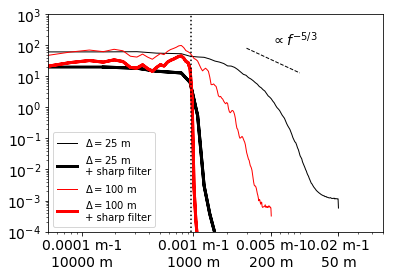

In [149]:
fig = plt.figure()
ax  = fig.add_subplot(111)

lw = 1
for datavar in [v_25,vals_filt_25]:
    n_west_east = 1200
    for i in range(n_west_east):

        xx  = datavar[i,:]

        if i==0:
            ff, pp = np.abs(welch(xx,fs=1/25.0))
        else:
            junk, now = np.abs(welch(xx,fs=1/25.0))
            pp = pp + now
    pp = pp/float(n_west_east)    
    label = "$\Delta=25$ m" if lw==1 else "$\Delta=25$ m"+"\n"+"+ sharp filter"
    ax.loglog(ff,pp,color='k',lw=lw,label=label)    
    lw += 2
    
    
lw = 1
for datavar in [vals_100_clip,vals_filt_100]:
    n_west_east = 300
    for i in range(n_west_east):

        xx  = datavar[i,:]

        if i==0:
            ff, pp = np.abs(welch(xx,fs=1/100.0))
        else:
            junk, now = np.abs(welch(xx,fs=1/100.0))
            pp = pp + now
    pp = pp/float(n_west_east)    
    label = "$\Delta=100$ m" if lw==1 else "$\Delta=100$ m"+"\n"+"+ sharp filter"
    ax.loglog(ff,pp,color='r',lw=lw,label=label)
    lw += 2    
    
ax.set_xlim([5e-5,5e-2])
ax.set_ylim([1e-4,1e3])

ref_f     = np.linspace(3e-3,9e-3,20)
ref_slope = ref_f**(-5/3) * 5e-3
ax.loglog(ref_f,ref_slope,'--k',lw=1)
ax.text(5e-3,1e2,'$\propto f^{{-5/3}}$') 

ax.axvline(x=10**f_cut_log,color='k',linestyle=":")

kappas = [50.0,200.,1000.,10000.0]
ax.set_xticks([1/q for q in kappas])
ax.set_xticklabels(["{0} m-1\n{1:.0f} m".format(1/q,q) for q in kappas])

plt.legend(loc=3,fontsize=10)

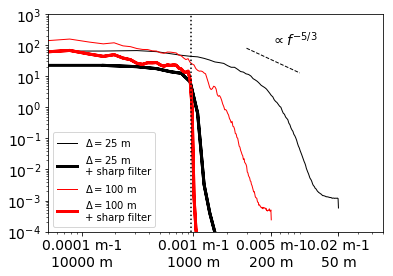

In [150]:
fig = plt.figure()
ax  = fig.add_subplot(111)

lw = 1
for datavar in [v_25,vals_filt_25]:
    n_west_east = 1200
    for i in range(n_west_east):

        xx  = datavar[:,i]

        if i==0:
            ff, pp = np.abs(welch(xx,fs=1/25.0))
        else:
            junk, now = np.abs(welch(xx,fs=1/25.0))
            pp = pp + now
    pp = pp/float(n_west_east)    
    label = "$\Delta=25$ m" if lw==1 else "$\Delta=25$ m"+"\n"+"+ sharp filter"
    ax.loglog(ff,pp,color='k',lw=lw,label=label)    
    lw += 2
    
    
lw = 1
for datavar in [vals_100_clip,vals_filt_100]:
    n_west_east = 300
    for i in range(n_west_east):

        xx  = datavar[:,i]

        if i==0:
            ff, pp = np.abs(welch(xx,fs=1/100.0))
        else:
            junk, now = np.abs(welch(xx,fs=1/100.0))
            pp = pp + now
    pp = pp/float(n_west_east)    
    label = "$\Delta=100$ m" if lw==1 else "$\Delta=100$ m"+"\n"+"+ sharp filter"
    ax.loglog(ff,pp,color='r',lw=lw,label=label)
    lw += 2    
    
ax.set_xlim([5e-5,5e-2])
ax.set_ylim([1e-4,1e3])

ref_f     = np.linspace(3e-3,9e-3,20)
ref_slope = ref_f**(-5/3) * 5e-3
ax.loglog(ref_f,ref_slope,'--k',lw=1)
ax.text(5e-3,1e2,'$\propto f^{{-5/3}}$') 

ax.axvline(x=10**f_cut_log,color='k',linestyle=":")

kappas = [50.,200.,1000.,10000.0]
ax.set_xticks([1/q for q in kappas])
ax.set_xticklabels(["{0} m-1\n{1:.0f} m".format(1/q,q) for q in kappas])


plt.legend(loc=3,fontsize=10)